In [205]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
import scipy
import theano.tensor as tt

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 62
    # data points      = 1000
    # variables        = 2
    chi-square         = 2.180
    reduced chi-square = 0.002
    Akaike info crit   = -6122.254
    Bayesian info crit = -6112.438
[[Variables]]
    decay:       18.9639300 +/- 0.544670 (2.87%) (init= 7842.802)
    amplitude:   1.03013495 +/- 0.020383 (1.98%) (init= 0.02889925)
[[Correlations]] (unreported correlations are <  0.250)
    C(decay, amplitude)          = -0.688 



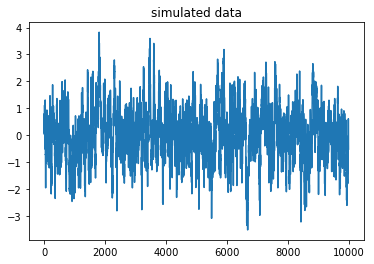

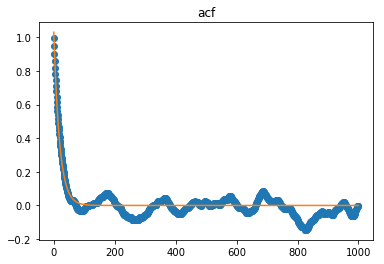

In [206]:
A,D = 1.0,1.0
delta_t=0.05
N=10000 # length of data set
P=1000 # range to fit acf

data = langevin.time_series(A=A,D=D,delta_t=delta_t,N=N)

plt.figure()
plt.plot(data)
plt.title('simulated data')

# calculate autocorrelation function
f = np.fft.rfft(data)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr=acf[int(N/2):]

y = autocorr[:min(int(N/2),P)]
t = np.arange(min(int(N/2),P))

mod=ExponentialModel()
pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.figure()
plt.plot(t,y,"o")
plt.plot(t,out.best_fit)
plt.title('acf')

In [207]:
sumsq = np.sum(data[1:-1]**2)
sumiplusone = np.sum(data[:-1]*data[1:])
print(sumsq,sumiplusone)

9969.43500107 9491.74023775


In [208]:
#calculate B_max
coef = [(N-1)*(data[0]**2+sumsq),
       (2.0-N)*sumiplusone,
       -(N+1)*data[0]**2-(N+1)*sumsq-N*data[-1]**2-data[-1]**2,
       N*sumiplusone]
f = np.poly1d(coef)

array([  4.15350959e+04,   3.89367065e+06,   7.66761398e+06,
         1.13639632e+07,   1.49833164e+07,   1.85262717e+07,
         2.19934272e+07,   2.53853810e+07,   2.87027312e+07,
         3.19460760e+07,   3.51160134e+07,   3.82131415e+07,
         4.12380585e+07,   4.41913624e+07,   4.70736513e+07,
         4.98855235e+07,   5.26275769e+07,   5.53004096e+07,
         5.79046199e+07,   6.04408057e+07,   6.29095652e+07,
         6.53114966e+07,   6.76471978e+07,   6.99172670e+07,
         7.21223024e+07,   7.42629020e+07,   7.63396639e+07,
         7.83531863e+07,   8.03040672e+07,   8.21929048e+07,
         8.40202971e+07,   8.57868423e+07,   8.74931384e+07,
         8.91397837e+07,   9.07273761e+07,   9.22565138e+07,
         9.37277949e+07,   9.51418175e+07,   9.64991797e+07,
         9.78004797e+07,   9.90463154e+07,   1.00237285e+08,
         1.01373987e+08,   1.02457019e+08,   1.03486979e+08,
         1.04464465e+08,   1.05390076e+08,   1.06264410e+08,
         1.07088064e+08,

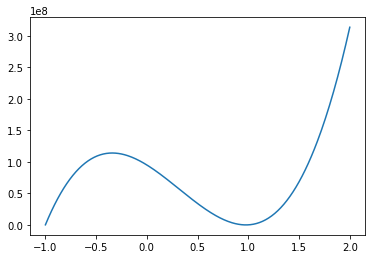

In [209]:
x=np.linspace(-1,2,301)
plt.plot(x,f(x))
f(x)

In [210]:
print(scipy.optimize.root(f,0.5))
print(np.roots(coef))

    fjac: array([[-1.]])
     fun: array([  1.49011612e-08])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-0.00086182])
       r: array([ 9464973.42390838])
  status: 1
 success: True
       x: array([ 0.9517246])
[-1.00010672  1.00037071  0.9517246 ]


In [211]:
print(np.exp(-delta_t))

0.951229424501


In [212]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        1 > B > 0, exp(-D/A*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [213]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=1000)

    B = pm.Uniform('B', lower=0, upper=1)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
    trace = pm.sample(10000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: 2464.184846
         Iterations: 2
         Function evaluations: 49


Average ELBO = -2,346.3: 100%|██████████| 200000/200000 [00:56<00:00, 3519.17it/s]
Finished [100%]: Average ELBO = -2,346.3
100%|██████████| 10000/10000 [01:08<00:00, 146.53it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ecae748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d6592b0>]], dtype=object)

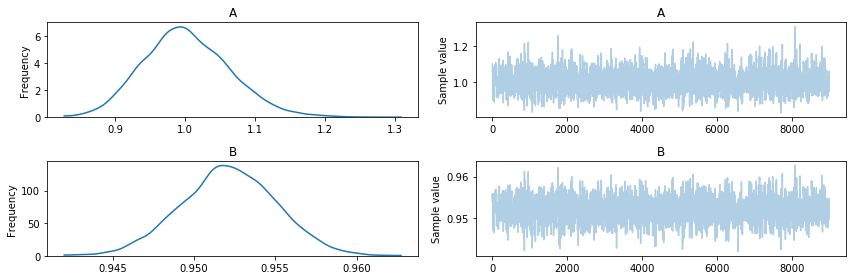

In [214]:
pm.traceplot(trace[1000:])

In [215]:
pm.summary(trace)


A:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.316            13.804           0.312            [0.886, 1.129]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.891          0.960          0.999          1.044          1.136


B:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.952            0.003            0.000            [0.946, 0.958]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.946          0.950          0.952          0.954          0.958

